<h1 id="oversampling_for_multiclass_classification_of_accidents">Oversampling on the Order of the Smallest Class for Multiclass Classification of Automobile Accidents in Seattle, Washington<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7fccecb76f70>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.418826045002788 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 16.839754090004135 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.017576033016667 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=["category", "integer"])

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.64241523097735 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_converted.head()

,X,Y,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,-122.320757054,47.609407946,1,Sideswipe,2,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,-122.319560827,47.662220664,1,Parked Car,2,0,0,2,0,0,0,Clear,Dry,Daylight
5,-122.374193726,47.564075600,1,Rear Ended,2,0,0,2,0,0,0,Clear,Dry,Daylight
6,-122.290734129,47.709276309,1,Other,2,0,0,1,0,0,0,Clear,Wet,Daylight
8,-122.336564829,47.590397830,1,Sideswipe,2,0,0,2,0,0,0,Overcast,Dry,Daylight


In [23]:
df_converted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   X                171872 non-null  float64 
 1   Y                171872 non-null  float64 
 2   SEVERITYCODE     171872 non-null  category
 3   COLLISIONTYPE    171872 non-null  category
 4   PERSONCOUNT      171872 non-null  int64   
 5   PEDCOUNT         171872 non-null  int64   
 6   PEDCYLCOUNT      171872 non-null  int64   
 7   VEHCOUNT         171872 non-null  int64   
 8   INJURIES         171872 non-null  int64   
 9   SERIOUSINJURIES  171872 non-null  int64   
 10  FATALITIES       171872 non-null  int64   
 11  WEATHER          171872 non-null  category
 12  ROADCOND         171872 non-null  category
 13  LIGHTCOND        171872 non-null  category
dtypes: category(5), float64(2), int64(7)
memory usage: 13.9 MB


In [24]:
df_integer = df_converted[['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES']]
df_integer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   PERSONCOUNT      171872 non-null  int64
 1   PEDCOUNT         171872 non-null  int64
 2   PEDCYLCOUNT      171872 non-null  int64
 3   VEHCOUNT         171872 non-null  int64
 4   INJURIES         171872 non-null  int64
 5   SERIOUSINJURIES  171872 non-null  int64
 6   FATALITIES       171872 non-null  int64
dtypes: int64(7)
memory usage: 10.5 MB


In [25]:
for feature in list(df_integer.columns):
    print(feature)
    print(df[feature].value_counts(normalize=True))
    print()

PERSONCOUNT
2    0.537547033
3    0.165053368
0    0.112878237
4    0.067808247
1    0.062853168
5    0.030674514
6    0.012620320
7    0.005329985
8    0.002470764
9    0.001025345
10   0.000600753
11   0.000266499
12   0.000158093
13   0.000099373
14   0.000099373
15   0.000049686
17   0.000049686
16   0.000036135
44   0.000027102
20   0.000027102
25   0.000027102
18   0.000027102
19   0.000027102
22   0.000022585
29   0.000018068
26   0.000018068
23   0.000013551
32   0.000013551
47   0.000013551
27   0.000013551
28   0.000013551
37   0.000013551
34   0.000013551
21   0.000009034
36   0.000009034
31   0.000009034
30   0.000009034
24   0.000009034
35   0.000004517
81   0.000004517
39   0.000004517
41   0.000004517
43   0.000004517
48   0.000004517
53   0.000004517
54   0.000004517
57   0.000004517
93   0.000004517
Name: PERSONCOUNT, Length: 48, dtype: float64

PEDCOUNT
0   0.963539291
1   0.035037875
2   0.001242157
3   0.000126474
4   0.000040652
5   0.000009034
6   0.000004517
Name

In [26]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,2,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,2,0,0,2,0,0,0,Clear,Dry,Daylight
5,1,Rear Ended,2,0,0,2,0,0,0,Clear,Dry,Daylight
6,1,Other,2,0,0,1,0,0,0,Clear,Wet,Daylight
8,1,Sideswipe,2,0,0,2,0,0,0,Overcast,Dry,Daylight


In [27]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PERSONCOUNT      171872 non-null  int64   
 3   PEDCOUNT         171872 non-null  int64   
 4   PEDCYLCOUNT      171872 non-null  int64   
 5   VEHCOUNT         171872 non-null  int64   
 6   INJURIES         171872 non-null  int64   
 7   SERIOUSINJURIES  171872 non-null  int64   
 8   FATALITIES       171872 non-null  int64   
 9   WEATHER          171872 non-null  category
 10  ROADCOND         171872 non-null  category
 11  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(7)
memory usage: 11.3 MB


In [28]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.648041988024488 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [32]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [33]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [34]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [35]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [36]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class 1 size =', class_1_size)
print('class 2 size =', class_2_size)
print('class 2b size =', class_2b_size)
print('class 3 size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority class size =', minority_class_size)

class 1 size = 113082
class 2 size = 55521
class 2b size = 2941
class 3 size = 328

minority class size = 328


In [37]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.846432504011318 seconds.


<h2 id='sample_size_class_3'>Balance the Dataset by Sampling all Classes Equally<\h2>

In [38]:
# Set the size of sample to take from each class of accident severity.
# To balance the dataset, ensure that all samples are of the same size.
sample_size_class_1 = np.int(class_3_size)
sample_size_class_2 = np.int(class_3_size)
sample_size_class_2b = np.int(class_3_size)
sample_size_class_3 = np.int(class_3_size)

In [39]:
# Sample all classes equally, with the number of samples equal to the size of class '3'.
# Replacement flag is boolean with value set as follows:
# If class_size > sample_size, then parameter replace is passed the value True.
# Otherwise, parameter replace is passed the value False.
replaceFlag = bool(class_1_size < sample_size_class_1)
print('bool(class_1_size < sample_size_class_1) = %s' % bool(class_1_size < sample_size_class_1))
df_class_1_sampled = df_class_1.sample(n=sample_size_class_1,replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_2_size < sample_size_class_2)
print('bool(class_2_size < sample_size_class_2) = %s' % bool(class_2_size < sample_size_class_2))
df_class_2_sampled = df_class_2.sample(n=sample_size_class_2, replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_2b_size < sample_size_class_2b)
print('bool(class_2b_size < sample_size_class_2b) = %s' % bool(class_2b_size < sample_size_class_2b))
df_class_2b_sampled = df_class_2b.sample(n=sample_size_class_2b, replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_3_size < sample_size_class_3)
print('bool(class_3_size < sample_size_class_3) = %s' % bool(class_3_size < sample_size_class_3))
df_class_3_sampled = df_class_3.sample(n=sample_size_class_3, replace=replaceFlag, axis='index', random_state=seed)

bool(class_1_size < sample_size_class_1) = False
bool(class_2_size < sample_size_class_2) = False
bool(class_2b_size < sample_size_class_2b) = False
bool(class_3_size < sample_size_class_3) = False


In [40]:
# Produce a new DataFrame by concatenating the minority class's DataFrame with the undersampled resamples of the non-minority classes.
df_balanced_not_shuffled = pd.concat([df_class_1_sampled, df_class_2_sampled, df_class_2b_sampled, df_class_3_sampled], axis='index')

In [41]:
# Shuffle the new balanced DataFrame and store it for subsequent train/test splits.
df_balanced_undersampled = shuffle(df_balanced_not_shuffled, random_state=seed)

In [42]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced_undersampled["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b    328
2     328
1     328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [43]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced_undersampled["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [44]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PERSONCOUNT      171872 non-null  int64   
 3   PEDCOUNT         171872 non-null  int64   
 4   PEDCYLCOUNT      171872 non-null  int64   
 5   VEHCOUNT         171872 non-null  int64   
 6   INJURIES         171872 non-null  int64   
 7   SERIOUSINJURIES  171872 non-null  int64   
 8   FATALITIES       171872 non-null  int64   
 9   WEATHER          171872 non-null  category
 10  ROADCOND         171872 non-null  category
 11  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(7)
memory usage: 11.3 MB


In [45]:
# X = df_balanced_undersampled[["COLLISIONTYPE", "WEATHER", "ROADCOND", "LIGHTCOND"]] # These features are beyond weather/road/light data.
#X = df_balanced_undersampled[["WEATHER", "ROADCOND", "LIGHTCOND"]] # These features only include weather/road/light data.
X = df_balanced_undersampled.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)

We also define the data for the target variable, SEVERITYCODE, by the array y:

In [46]:
y = df_balanced_undersampled["SEVERITYCODE"].to_numpy()

In [47]:
print_elapsed_time(notebook_start_time)

Elapsed time is 22.13542193797184 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [48]:
# Create a OneHotEncoder and fit it to the features.
# Transform the data into a sparse matrix by passing the parameter sparse=True by default.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True)
X = encoder.fit_transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.categories_)

Fitting OneHotEncoder to training data...
Completed in 0.064281088009011 seconds.
[array(['Angles', 'Cycles', 'Head On', 'Left Turn', 'Other', 'Parked Car',
       'Pedestrian', 'Rear Ended', 'Right Turn', 'Sideswipe'],
      dtype=object), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 14, 31, 93]), array([0, 1, 2, 3, 4]), array([0, 1, 2]), array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array(['Clear', 'Fog/Smog/Smoke', 'Other', 'Overcast', 'Partly Cloudy',
       'Raining', 'Severe Crosswind', 'Snowing'], dtype=object), array(['Dry', 'Ice', 'Snow/Slush', 'Standing Water', 'Wet'], dtype=object), array(['Dark - No Street Lights', 'Dark - Street Lights Off',
       'Dark - Street Lights On', 'Dawn', 'Daylight', 'Dusk', 'Other'],
      dtype=object)]


In [49]:
type(X)

scipy.sparse.csr.csr_matrix

In [50]:
X.shape

(1312, 62)

In [51]:
y.shape

(1312,)

In [52]:
print_elapsed_time(notebook_start_time)

Elapsed time is 22.679730709991418 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [53]:
print(sorted(sklearn.metrics.SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


In [54]:
t0 = default_timer()
kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_micro', 'neg_log_loss','precision_micro', 'recall_micro']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print('Logistic Regression classifiers constructed in %f seconds.' % elapsed_time(t0))

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_micro', 'test_neg_log_loss', 'test_precision_micro', 'test_recall_micro']
Logistic Regression classifiers constructed in 12.720417 seconds.


In [55]:
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

fit_time: mean = 1.255376, std = 0.141140
fit_time :[1.47523117 0.99960113 1.33855677 1.09093857 1.14557052 1.33106613
 1.42370725 1.30895877 1.21904516 1.22108412]

score_time: mean = 0.066240, std = 0.012258
score_time :[0.07847619 0.07219601 0.05836296 0.04423881 0.06349444 0.06668997
 0.08848214 0.0643878  0.07410145 0.05197358]

test_f1_micro: mean = 0.472519, std = 0.028321
test_f1_micro :[0.46212121 0.53787879 0.44274809 0.47328244 0.47328244 0.44274809
 0.47328244 0.44274809 0.50381679 0.47328244]

test_neg_log_loss: mean = -1.160988, std = 0.075022
test_neg_log_loss :[-1.10126036 -1.13181141 -1.18225956 -1.2286032  -1.09603248 -1.32782476
 -1.05452535 -1.18717339 -1.11459859 -1.18578738]

test_precision_micro: mean = 0.472519, std = 0.028321
test_precision_micro :[0.46212121 0.53787879 0.44274809 0.47328244 0.47328244 0.44274809
 0.47328244 0.44274809 0.50381679 0.47328244]

test_recall_micro: mean = 0.472519, std = 0.028321
test_recall_micro :[0.46212121 0.53787879 0.44274809

In [56]:
print_elapsed_time(notebook_start_time)

Elapsed time is 35.82760492700618 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [57]:
print(sorted(sklearn.metrics.SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


In [58]:
t0 = default_timer()
kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=1000), verbose=True)
scoring = ['f1_micro', 'precision_micro', 'recall_micro']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print('Support Vector Machine classifiers constructed in %f seconds.' % elapsed_time(t0))

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_micro', 'test_precision_micro', 'test_recall_micro']
Support Vector Machine classifiers constructed in 4.461105 seconds.


In [59]:
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

fit_time: mean = 0.825508, std = 0.088262
fit_time :[0.86935449 0.90752459 0.82644701 0.99318433 0.75300193 0.86207461
 0.7593441  0.75365019 0.85942864 0.67107391]

score_time: mean = 0.028197, std = 0.007650
score_time :[0.03532672 0.04127979 0.02436376 0.03871536 0.02276444 0.0311892
 0.02624083 0.02492642 0.01874447 0.01841831]

test_f1_micro: mean = 0.464145, std = 0.027864
test_f1_micro :[0.47727273 0.49242424 0.41984733 0.48091603 0.45038168 0.41984733
 0.48091603 0.44274809 0.50381679 0.47328244]

test_precision_micro: mean = 0.464145, std = 0.027864
test_precision_micro :[0.47727273 0.49242424 0.41984733 0.48091603 0.45038168 0.41984733
 0.48091603 0.44274809 0.50381679 0.47328244]

test_recall_micro: mean = 0.464145, std = 0.027864
test_recall_micro :[0.47727273 0.49242424 0.41984733 0.48091603 0.45038168 0.41984733
 0.48091603 0.44274809 0.50381679 0.47328244]



In [60]:
print_elapsed_time(notebook_start_time)

Elapsed time is 40.670524279994424 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [61]:
print(sorted(sklearn.metrics.SCORERS.keys()))

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weighted', 'roc_auc_ovr', 'roc_auc_ovr_weighted', 'v_measure_score']


In [76]:
# grid_search_cv = GridSearchCV(estimator, param_grid, *, scoring=None, n_jobs=None, iid='deprecated', refit=True, cv=None, verbose=0, 
#     pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)
t0 = default_timer()
knn_clf = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, p=1)
#knn_clf.set_params('algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'p': 1)
grid_parameters = {'n_neighbors':range(3, 300, 2), 'weights':['distance', 'uniform']}
grid_search_cv = GridSearchCV(knn_clf, param_grid=grid_parameters, scoring=['f1_micro', 'precision_micro', 'recall_micro'], \
                              n_jobs=-1, iid='deprecated', refit='f1_micro', cv=10, verbose=1, pre_dispatch=10000, error_score='raise',\
                              return_train_score=False)
grid_search_cv.fit(X, y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  40 | elapsed:    5.0s remaining:   44.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    7.5s finished


GridSearchCV(cv=10, error_score='raise',
             estimator=KNeighborsClassifier(n_jobs=-1, p=1), n_jobs=-1,
             param_grid={'n_neighbors': range(61, 65, 2),
                         'weights': ['distance', 'uniform']},
             pre_dispatch=10000, refit='f1_micro',
             scoring=['f1_micro', 'precision_micro', 'recall_micro'],
             verbose=1)

In [78]:
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

Completed grid search in 21.729493 seconds


In [79]:
print('Best Estimator:', grid_search_cv.best_estimator_)
print()
print('Best estimator parameters:')
for key in grid_search_cv.best_estimator_.get_params().keys():
    print('\t', key, ':', grid_search_cv.best_estimator_.get_params()[key])

Best Estimator: KNeighborsClassifier(n_jobs=-1, n_neighbors=63, p=1)

Best estimator parameters:
	 algorithm : auto
	 leaf_size : 30
	 metric : minkowski
	 metric_params : None
	 n_jobs : -1
	 n_neighbors : 63
	 p : 1
	 weights : uniform


In [65]:
t0 = default_timer()
knn_clf = grid_search_cv.best_estimator_
kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scoring = ['f1_micro', 'precision_micro', 'recall_micro']
k_neighbors_scores = cross_validate(knn_clf, X, y, scoring=scoring, n_jobs=-1, cv=kfold_cv, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_micro', 'test_precision_micro', 'test_recall_micro']
k-Neighbors Classifiers constructed in 6.670778 seconds.


In [66]:
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

fit_time: mean = 0.013046, std = 0.004738
fit_time :[0.01382375 0.01096416 0.00757003 0.01567864 0.00822425 0.00848055
 0.0118947  0.01152039 0.01982427 0.02247429]

score_time: mean = 0.165166, std = 0.055443
score_time :[0.2447679  0.11699939 0.09938884 0.11928511 0.10966706 0.11553359
 0.1913693  0.23779058 0.19422197 0.22263193]

test_f1_micro: mean = 0.455766, std = 0.040870
test_f1_micro :[0.49242424 0.45454545 0.44274809 0.53435115 0.48091603 0.38167939
 0.44274809 0.40458015 0.45801527 0.46564885]

test_precision_micro: mean = 0.455766, std = 0.040870
test_precision_micro :[0.49242424 0.45454545 0.44274809 0.53435115 0.48091603 0.38167939
 0.44274809 0.40458015 0.45801527 0.46564885]

test_recall_micro: mean = 0.455766, std = 0.040870
test_recall_micro :[0.49242424 0.45454545 0.44274809 0.53435115 0.48091603 0.38167939
 0.44274809 0.40458015 0.45801527 0.46564885]



In [67]:
print_elapsed_time(notebook_start_time)

Elapsed time is 169.08959040400805 seconds.


## Sanity Check

In [68]:
t0 = default_timer()

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, shuffle=True, stratify=y)

Logistic Regression Model 1 of 10:
              precision    recall  f1-score   support

           1   0.640625  0.621212  0.630769        66
           2   0.473684  0.553846  0.510638        65
          2b   0.512195  0.318182  0.392523        66
           3   0.512195  0.636364  0.567568        66

    accuracy                       0.532319       263
   macro avg   0.534675  0.532401  0.525375       263
weighted avg   0.534907  0.532319  0.525431       263



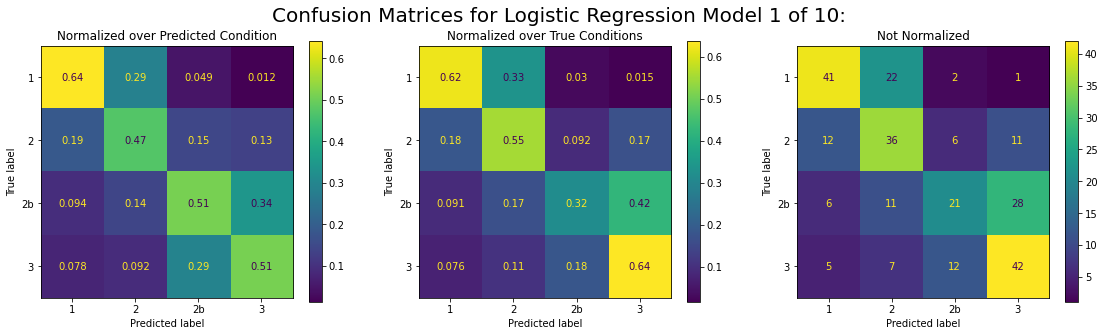

Logistic Regression Model 2 of 10:
              precision    recall  f1-score   support

           1   0.676923  0.666667  0.671756        66
           2   0.519481  0.615385  0.563380        65
          2b   0.555556  0.378788  0.450450        66
           3   0.565789  0.651515  0.605634        66

    accuracy                       0.577947       263
   macro avg   0.579437  0.578089  0.572805       263
weighted avg   0.579665  0.577947  0.572841       263



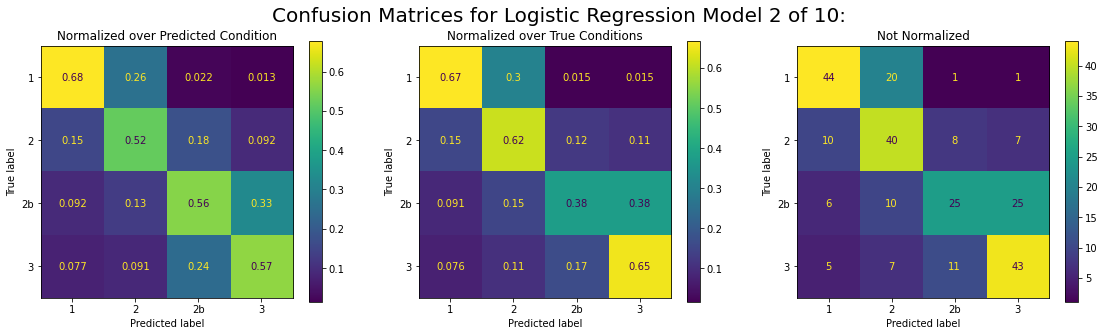

Logistic Regression Model 3 of 10:
              precision    recall  f1-score   support

           1   0.671875  0.651515  0.661538        66
           2   0.506494  0.600000  0.549296        65
          2b   0.605263  0.348485  0.442308        66
           3   0.523810  0.666667  0.586667        66

    accuracy                       0.566540       263
   macro avg   0.576860  0.566667  0.559952       263
weighted avg   0.577128  0.566540  0.559993       263



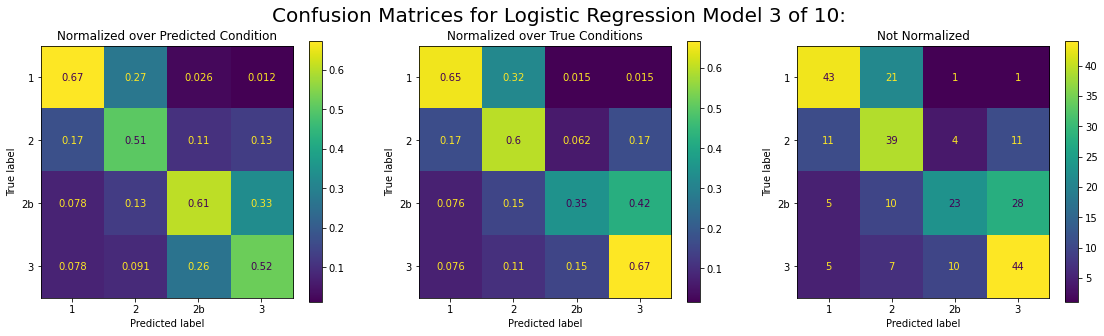

Logistic Regression Model 4 of 10:
              precision    recall  f1-score   support

           1   0.676923  0.666667  0.671756        66
           2   0.530303  0.538462  0.534351        65
          2b   0.528302  0.424242  0.470588        66
           3   0.531646  0.636364  0.579310        66

    accuracy                       0.566540       263
   macro avg   0.566793  0.566434  0.564001       263
weighted avg   0.566932  0.566540  0.564114       263



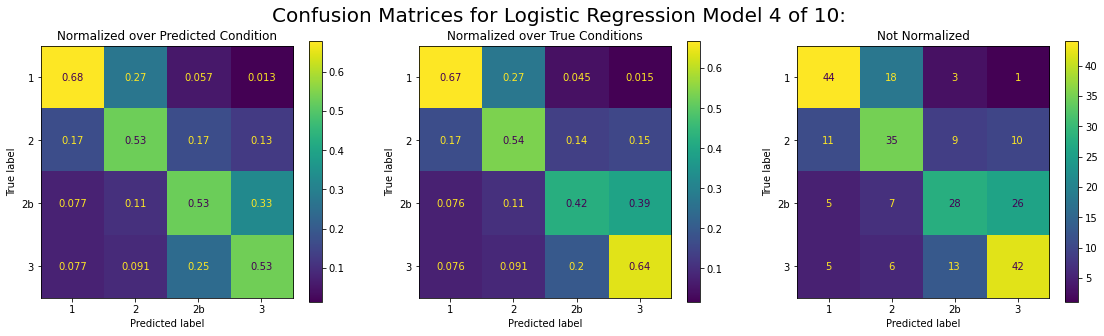

Logistic Regression Model 5 of 10:
              precision    recall  f1-score   support

           1   0.714286  0.606061  0.655738        66
           2   0.476744  0.630769  0.543046        65
          2b   0.547619  0.348485  0.425926        66
           3   0.531646  0.636364  0.579310        66

    accuracy                       0.555133       263
   macro avg   0.567574  0.555420  0.551005       263
weighted avg   0.567919  0.555133  0.551035       263



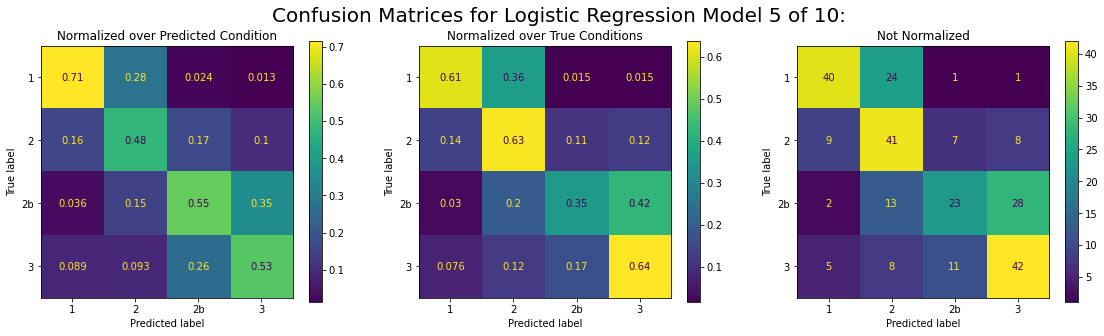

Logistic Regression Model 6 of 10:
              precision    recall  f1-score   support

           1   0.693548  0.651515  0.671875        66
           2   0.475000  0.584615  0.524138        65
          2b   0.511628  0.333333  0.403670        66
           3   0.551282  0.651515  0.597222        66

    accuracy                       0.555133       263
   macro avg   0.557865  0.555245  0.549226       263
weighted avg   0.558180  0.555133  0.549322       263



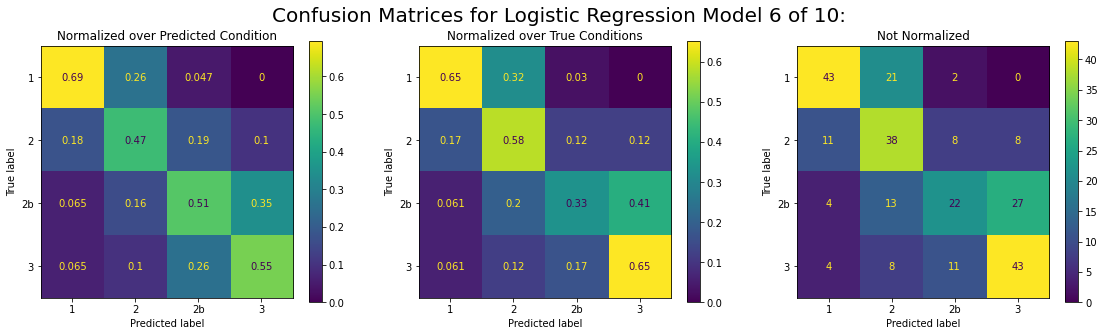

Logistic Regression Model 7 of 10:
              precision    recall  f1-score   support

           1   0.619718  0.666667  0.642336        66
           2   0.485294  0.507692  0.496241        65
          2b   0.521739  0.363636  0.428571        66
           3   0.551282  0.651515  0.597222        66

    accuracy                       0.547529       263
   macro avg   0.544508  0.547378  0.541093       263
weighted avg   0.544734  0.547529  0.541263       263



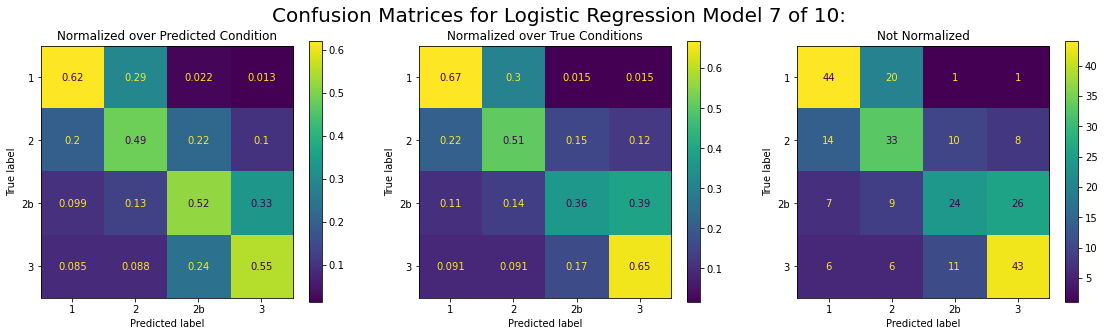

Logistic Regression Model 8 of 10:
              precision    recall  f1-score   support

           1   0.626866  0.636364  0.631579        66
           2   0.506494  0.600000  0.549296        65
          2b   0.578947  0.333333  0.423077        66
           3   0.555556  0.681818  0.612245        66

    accuracy                       0.562738       263
   macro avg   0.566966  0.562879  0.554049       263
weighted avg   0.567195  0.562738  0.554067       263



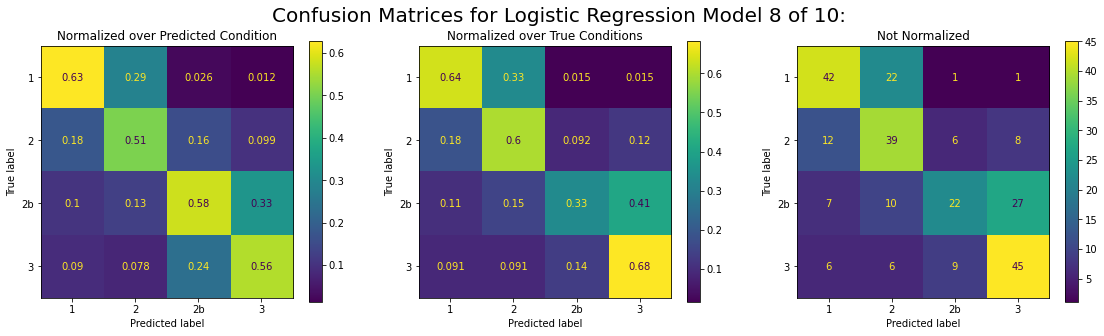

Logistic Regression Model 9 of 10:
              precision    recall  f1-score   support

           1   0.600000  0.636364  0.617647        66
           2   0.464789  0.507692  0.485294        65
          2b   0.478261  0.333333  0.392857        66
           3   0.539474  0.621212  0.577465        66

    accuracy                       0.524715       263
   macro avg   0.520631  0.524650  0.518316       263
weighted avg   0.520843  0.524715  0.518441       263



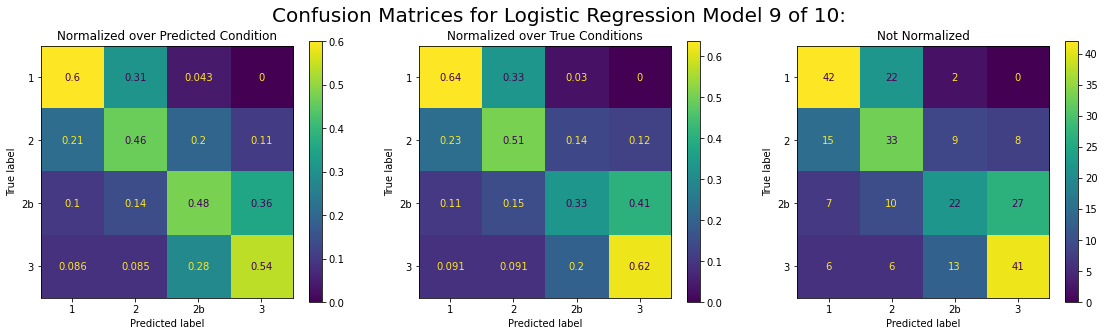

Logistic Regression Model 10 of 10:
              precision    recall  f1-score   support

           1   0.677419  0.636364  0.656250        66
           2   0.525641  0.630769  0.573427        65
          2b   0.567568  0.318182  0.407767        66
           3   0.523256  0.681818  0.592105        66

    accuracy                       0.566540       263
   macro avg   0.573471  0.566783  0.557387       263
weighted avg   0.573653  0.566540  0.557326       263



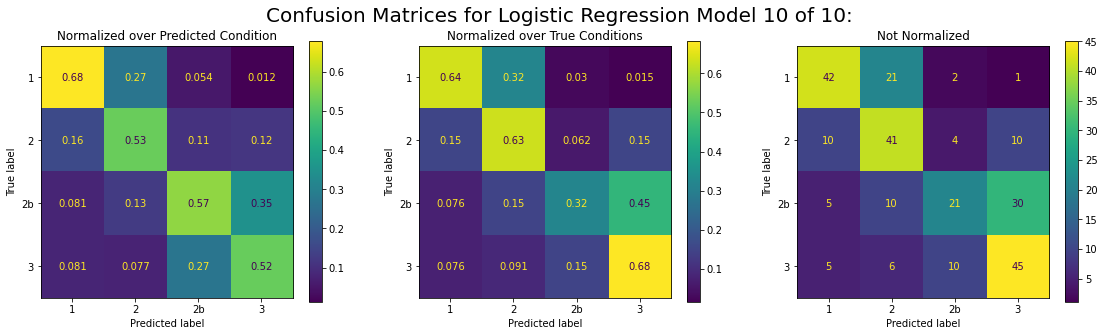

In [70]:
# For each logistic regression classifier in the cross-validation, print the score report and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    #lr_clf_score = logistic_regression_clf.score(X_test, y_test)
    y_test_predicted = logistic_regression_clf.predict(X_test)
    #lr_clf_jaccard_scores = jaccard_score(y_test, y_test_predicted, average=None, labels=['1', '2', '2b', '3'])
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    #print('mean accuracy =', lr_clf_score)
    #print('Jaccard scores by class:', lr_clf_jaccard_scores)
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regression Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [71]:
print_elapsed_time(notebook_start_time)

Elapsed time is 203.94725000299513 seconds.


Support Vector Machine Model 1 of 10:
              precision    recall  f1-score   support

           1   0.617647  0.636364  0.626866        66
           2   0.514286  0.553846  0.533333        65
          2b   0.575000  0.348485  0.433962        66
           3   0.529412  0.681818  0.596026        66

    accuracy                       0.555133       263
   macro avg   0.559086  0.555128  0.547547       263
weighted avg   0.559256  0.555133  0.547601       263



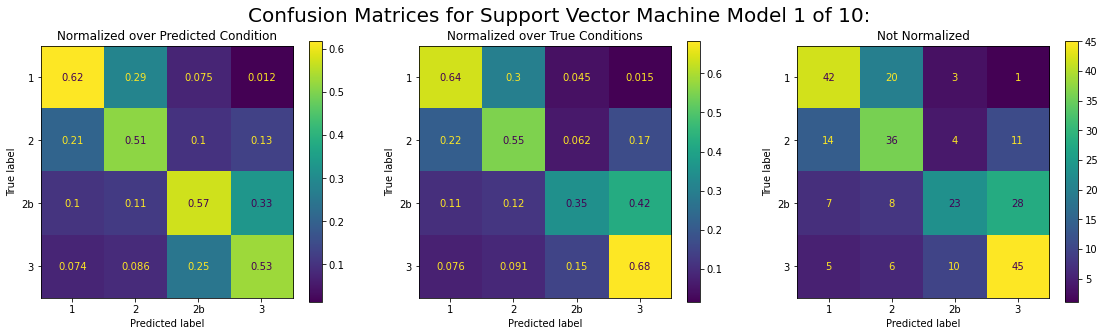

Support Vector Machine Model 2 of 10:
              precision    recall  f1-score   support

           1   0.672131  0.621212  0.645669        66
           2   0.547945  0.615385  0.579710        65
          2b   0.521739  0.363636  0.428571        66
           3   0.542169  0.681818  0.604027        66

    accuracy                       0.570342       263
   macro avg   0.570996  0.570513  0.564494       263
weighted avg   0.571084  0.570342  0.564437       263



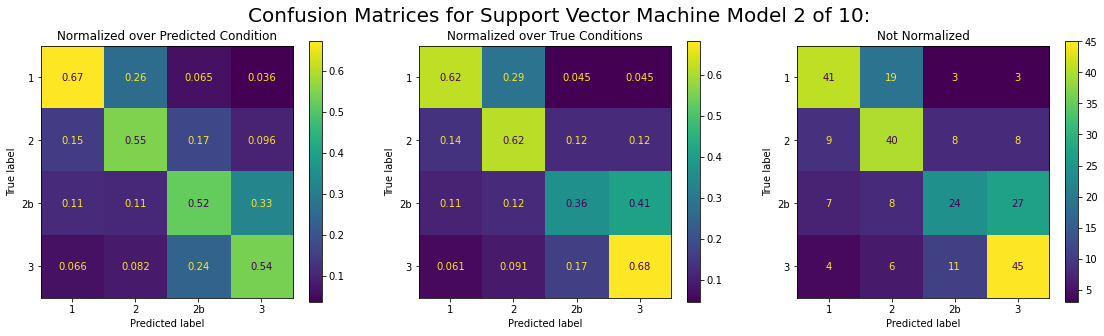

Support Vector Machine Model 3 of 10:
              precision    recall  f1-score   support

           1   0.656716  0.666667  0.661654        66
           2   0.520548  0.584615  0.550725        65
          2b   0.600000  0.318182  0.415842        66
           3   0.522727  0.696970  0.597403        66

    accuracy                       0.566540       263
   macro avg   0.574998  0.566608  0.556406       263
weighted avg   0.575205  0.566540  0.556427       263



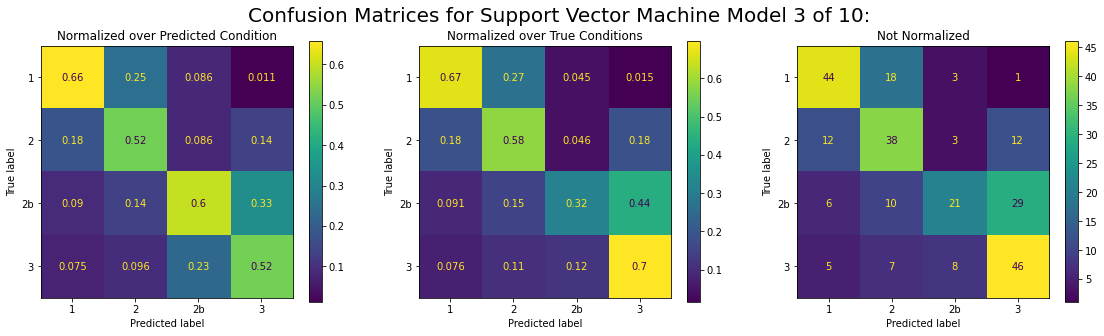

Support Vector Machine Model 4 of 10:
              precision    recall  f1-score   support

           1   0.671875  0.651515  0.661538        66
           2   0.528571  0.569231  0.548148        65
          2b   0.604651  0.393939  0.477064        66
           3   0.534884  0.696970  0.605263        66

    accuracy                       0.577947       263
   macro avg   0.584995  0.577914  0.573003       263
weighted avg   0.585210  0.577947  0.573098       263



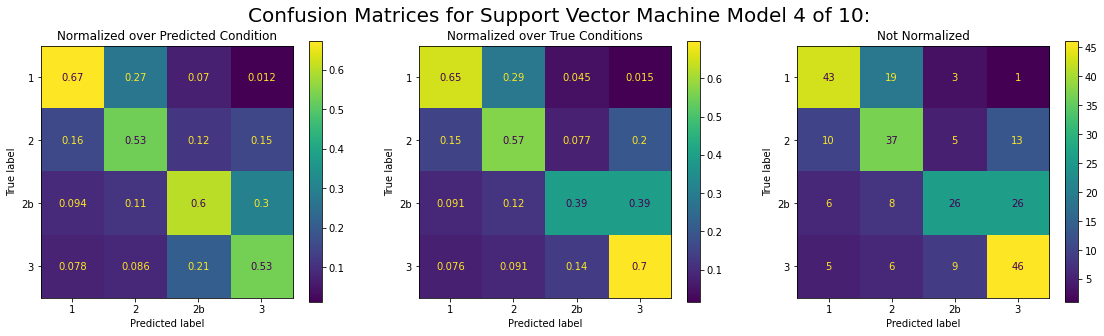

Support Vector Machine Model 5 of 10:
              precision    recall  f1-score   support

           1   0.701754  0.606061  0.650407        66
           2   0.500000  0.630769  0.557823        65
          2b   0.560976  0.348485  0.429907        66
           3   0.530120  0.666667  0.590604        66

    accuracy                       0.562738       263
   macro avg   0.573213  0.562995  0.557185       263
weighted avg   0.573491  0.562738  0.557183       263



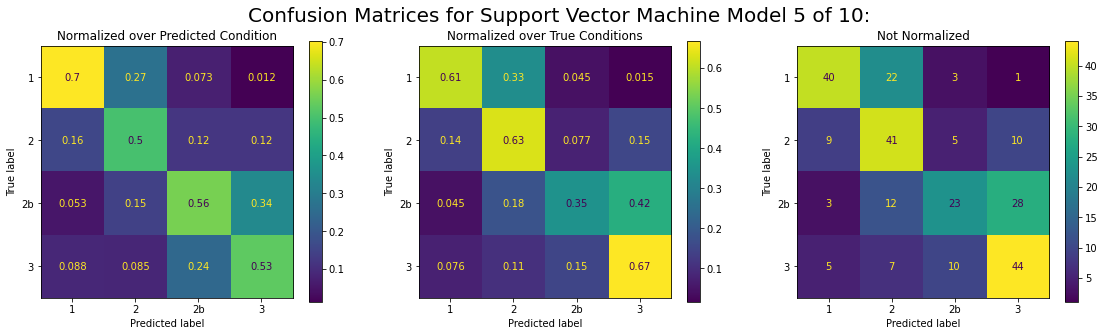

Support Vector Machine Model 6 of 10:
              precision    recall  f1-score   support

           1   0.651515  0.651515  0.651515        66
           2   0.487179  0.584615  0.531469        65
          2b   0.612903  0.287879  0.391753        66
           3   0.545455  0.727273  0.623377        66

    accuracy                       0.562738       263
   macro avg   0.574263  0.562821  0.549528       263
weighted avg   0.574594  0.562738  0.549597       263



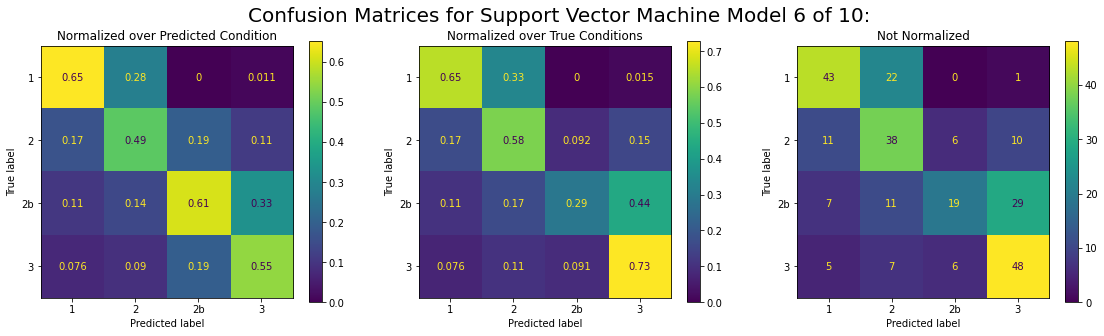

Support Vector Machine Model 7 of 10:
              precision    recall  f1-score   support

           1   0.637681  0.666667  0.651852        66
           2   0.473684  0.553846  0.510638        65
          2b   0.500000  0.242424  0.326531        66
           3   0.523256  0.681818  0.592105        66

    accuracy                       0.536122       263
   macro avg   0.533655  0.536189  0.520282       263
weighted avg   0.533883  0.536122  0.520318       263



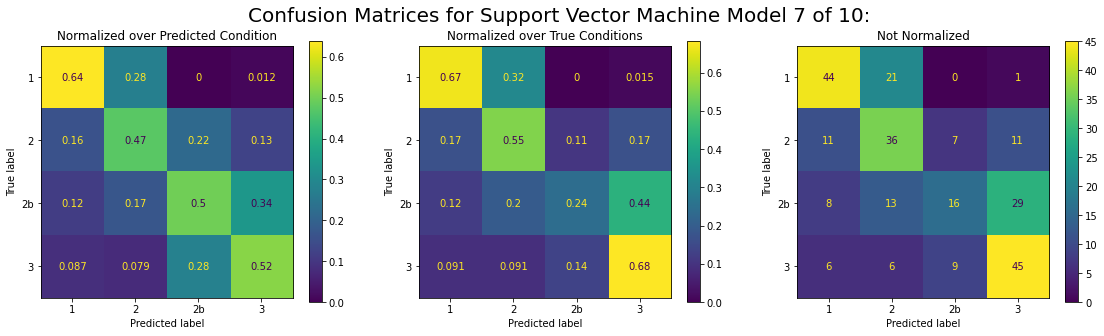

Support Vector Machine Model 8 of 10:
              precision    recall  f1-score   support

           1   0.623188  0.651515  0.637037        66
           2   0.500000  0.615385  0.551724        65
          2b   0.560000  0.212121  0.307692        66
           3   0.516854  0.696970  0.593548        66

    accuracy                       0.543726       263
   macro avg   0.550011  0.543998  0.522500       263
weighted avg   0.550201  0.543726  0.522389       263



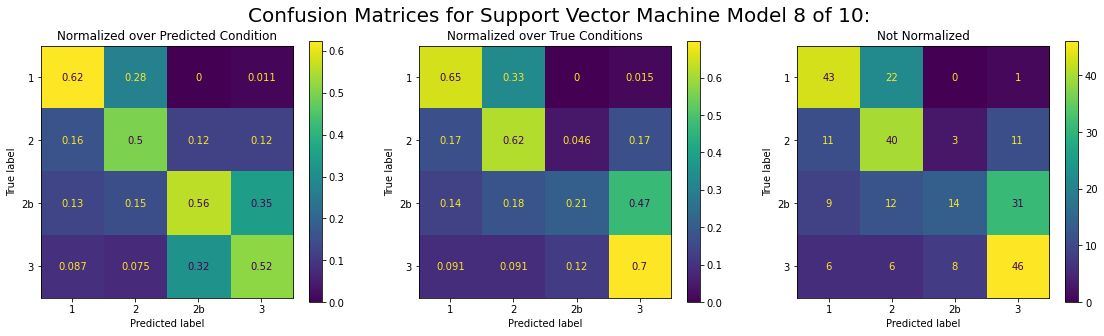

Support Vector Machine Model 9 of 10:
              precision    recall  f1-score   support

           1   0.617647  0.636364  0.626866        66
           2   0.475000  0.584615  0.524138        65
          2b   0.533333  0.242424  0.333333        66
           3   0.517647  0.666667  0.582781        66

    accuracy                       0.532319       263
   macro avg   0.535907  0.532517  0.516780       263
weighted avg   0.536138  0.532319  0.516752       263



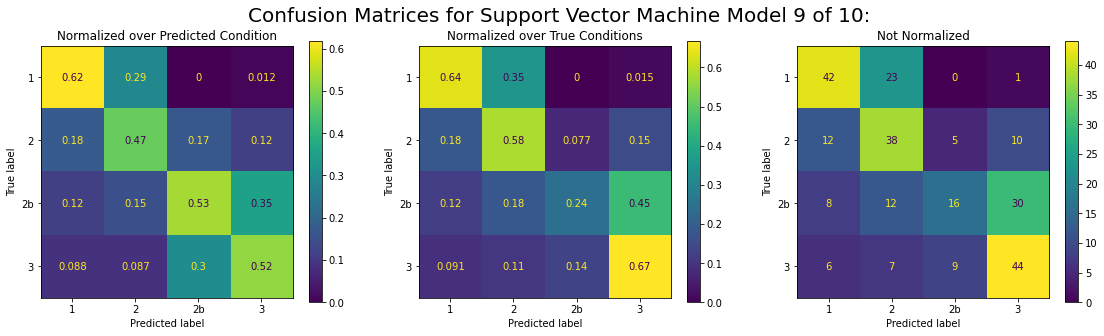

Support Vector Machine Model 10 of 10:
              precision    recall  f1-score   support

           1   0.641791  0.651515  0.646617        66
           2   0.506494  0.600000  0.549296        65
          2b   0.612903  0.287879  0.391753        66
           3   0.522727  0.696970  0.597403        66

    accuracy                       0.558935       263
   macro avg   0.570979  0.559091  0.546267       263
weighted avg   0.571224  0.558935  0.546255       263



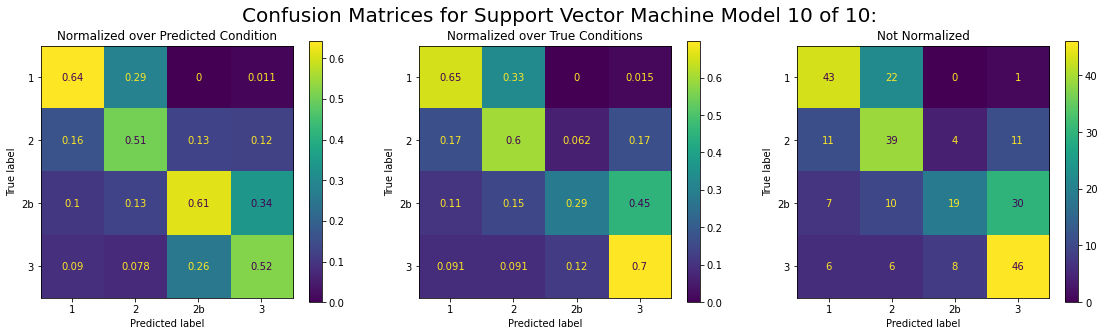

In [72]:
# For each support vector machine classifier in the cross-validation, print the score report and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    #linear_svc_score = linear_svc_clf.score(X_test, y_test)
    y_test_predicted = linear_svc_clf.predict(X_test)
    #linear_svc_jaccard_scores = jaccard_score(y_test, y_test_predicted, average=None, labels=['1', '2', '2b', '3'])
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    #print('mean accuracy =', linear_svc_score)
    #print('Jaccard scores by class:', linear_svc_jaccard_scores)
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,3,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1,3,2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1,3,3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)
    
    plt.show()

k-Nearest Neighbor Model 1 of 10:
              precision    recall  f1-score   support

           1   0.553191  0.787879  0.650000        66
           2   0.465753  0.523077  0.492754        65
          2b   0.562500  0.136364  0.219512        66
           3   0.537500  0.651515  0.589041        66

    accuracy                       0.524715       263
   macro avg   0.529736  0.524709  0.487827       263
weighted avg   0.529980  0.524715  0.487808       263



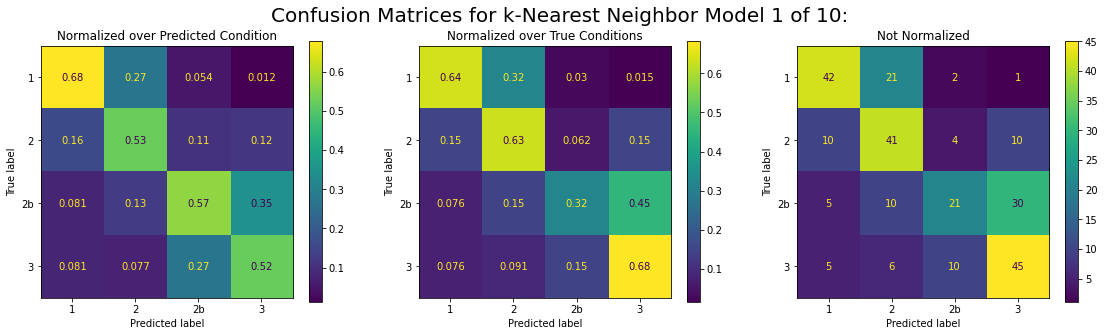

k-Nearest Neighbor Model 2 of 10:
              precision    recall  f1-score   support

           1   0.529412  0.818182  0.642857        66
           2   0.507937  0.492308  0.500000        65
          2b   0.500000  0.181818  0.266667        66
           3   0.554054  0.621212  0.585714        66

    accuracy                       0.528517       263
   macro avg   0.522851  0.528380  0.498810       263
weighted avg   0.522907  0.528517  0.498805       263



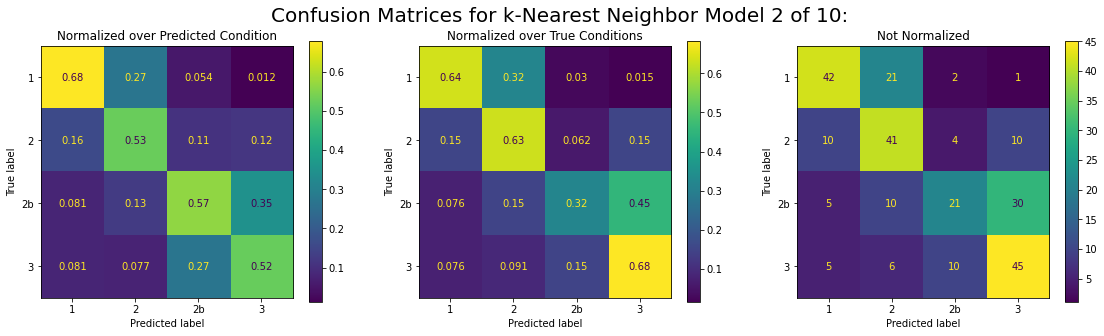

k-Nearest Neighbor Model 3 of 10:
              precision    recall  f1-score   support

           1   0.544554  0.833333  0.658683        66
           2   0.476923  0.476923  0.476923        65
          2b   0.529412  0.136364  0.216867        66
           3   0.525000  0.636364  0.575342        66

    accuracy                       0.520913       263
   macro avg   0.518972  0.520746  0.481954       263
weighted avg   0.519132  0.520913  0.481973       263



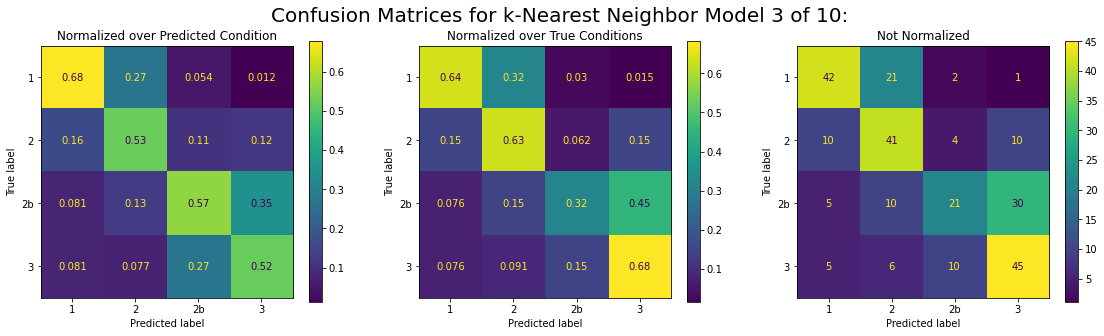

k-Nearest Neighbor Model 4 of 10:
              precision    recall  f1-score   support

           1   0.538462  0.848485  0.658824        66
           2   0.500000  0.476923  0.488189        65
          2b   0.526316  0.151515  0.235294        66
           3   0.525641  0.621212  0.569444        66

    accuracy                       0.524715       263
   macro avg   0.522605  0.524534  0.487938       263
weighted avg   0.522691  0.524715  0.487937       263



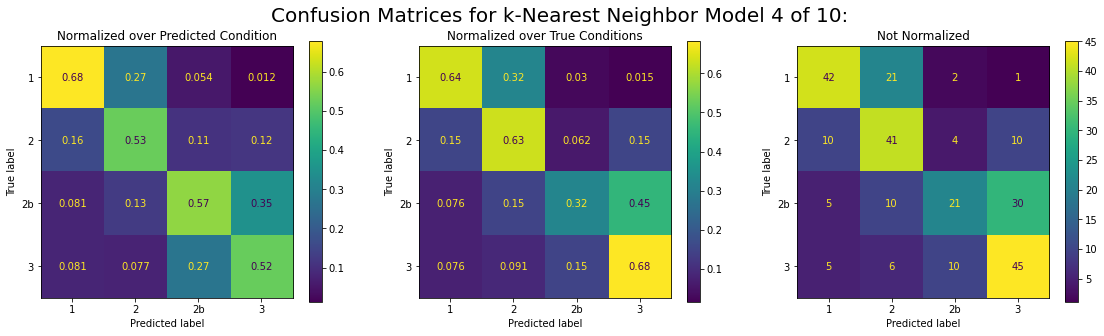

k-Nearest Neighbor Model 5 of 10:
              precision    recall  f1-score   support

           1   0.545455  0.818182  0.654545        66
           2   0.492537  0.507692  0.500000        65
          2b   0.529412  0.136364  0.216867        66
           3   0.525000  0.636364  0.575342        66

    accuracy                       0.524715       263
   macro avg   0.523101  0.524650  0.486689       263
weighted avg   0.523217  0.524715  0.486638       263



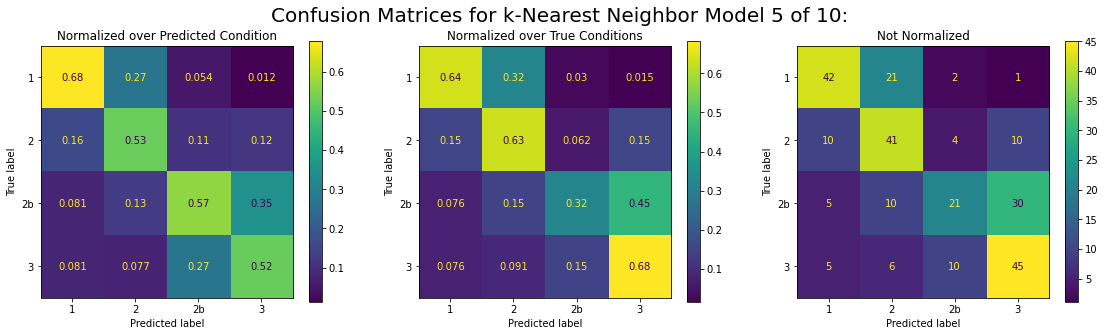

k-Nearest Neighbor Model 6 of 10:
              precision    recall  f1-score   support

           1   0.575758  0.863636  0.690909        66
           2   0.477612  0.492308  0.484848        65
          2b   0.476190  0.151515  0.229885        66
           3   0.526316  0.606061  0.563380        66

    accuracy                       0.528517       263
   macro avg   0.513969  0.528380  0.492256       263
weighted avg   0.514107  0.528517  0.492284       263



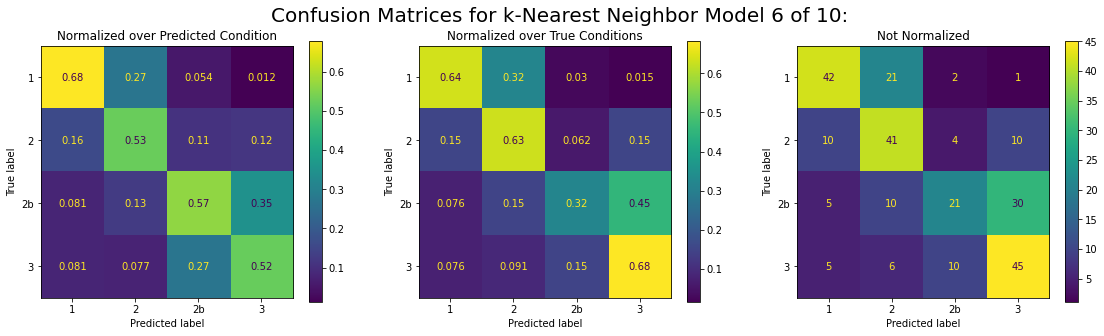

k-Nearest Neighbor Model 7 of 10:
              precision    recall  f1-score   support

           1   0.533981  0.833333  0.650888        66
           2   0.476923  0.476923  0.476923        65
          2b   0.562500  0.136364  0.219512        66
           3   0.544304  0.651515  0.593103        66

    accuracy                       0.524715       263
   macro avg   0.529427  0.524534  0.485107       263
weighted avg   0.529626  0.524715  0.485138       263



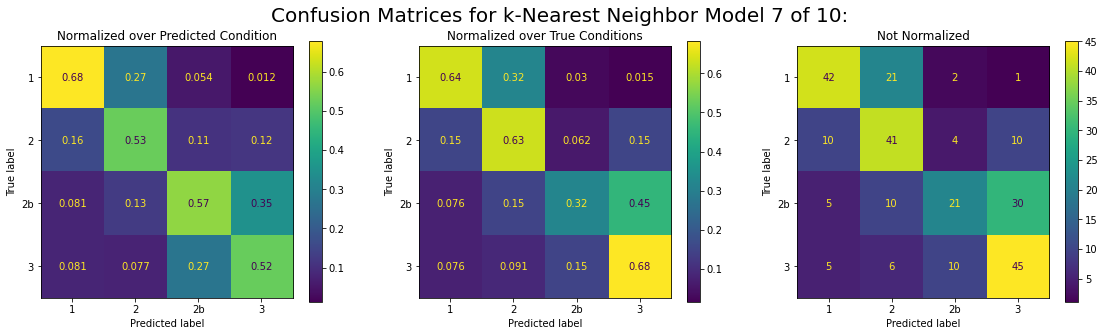

k-Nearest Neighbor Model 8 of 10:
              precision    recall  f1-score   support

           1   0.533981  0.833333  0.650888        66
           2   0.492063  0.476923  0.484375        65
          2b   0.555556  0.151515  0.238095        66
           3   0.531646  0.636364  0.579310        66

    accuracy                       0.524715       263
   macro avg   0.528311  0.524534  0.488167       263
weighted avg   0.528449  0.524715  0.488181       263



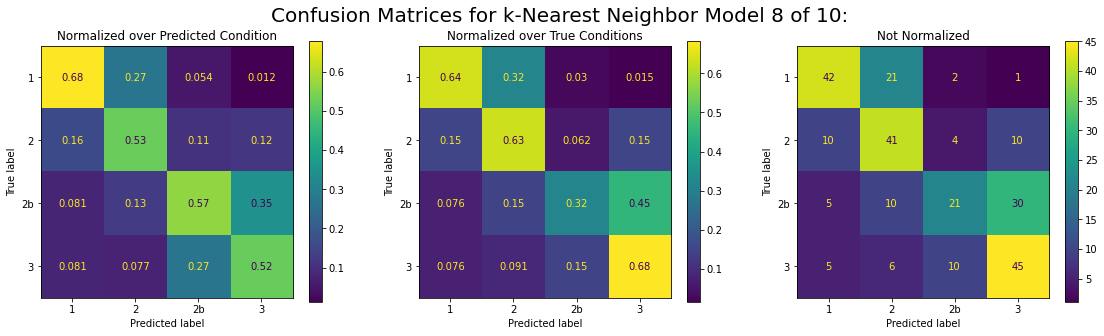

k-Nearest Neighbor Model 9 of 10:
              precision    recall  f1-score   support

           1   0.519231  0.818182  0.635294        66
           2   0.500000  0.476923  0.488189        65
          2b   0.387097  0.181818  0.247423        66
           3   0.484848  0.484848  0.484848        66

    accuracy                       0.490494       263
   macro avg   0.472794  0.490443  0.463939       263
weighted avg   0.472691  0.490494  0.463846       263



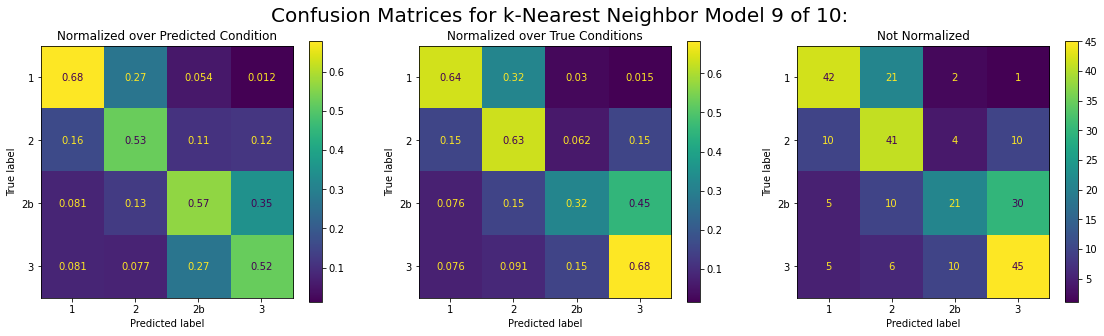

k-Nearest Neighbor Model 10 of 10:
              precision    recall  f1-score   support

           1   0.534653  0.818182  0.646707        66
           2   0.500000  0.492308  0.496124        65
          2b   0.562500  0.136364  0.219512        66
           3   0.536585  0.666667  0.594595        66

    accuracy                       0.528517       263
   macro avg   0.533435  0.528380  0.489234       263
weighted avg   0.533562  0.528517  0.489208       263



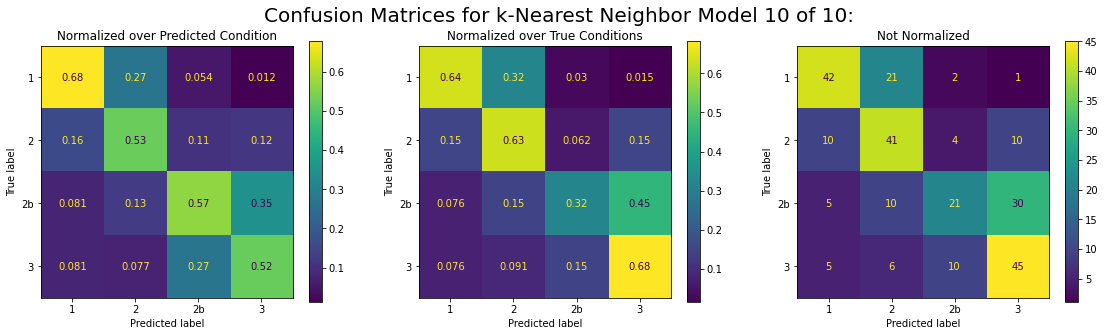

In [75]:
# For each k-Nearest Neighbor classifier in the cross-validation, print the score report and confusion matrices.
number_of_models = len(k_neighbors_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, knn_clf in zip(range(len(k_neighbors_scores['estimator'])), k_neighbors_scores['estimator']):
    y_test_predicted = knn_clf.predict(X_test)
    print('k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models))
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [71]:
print_elapsed_time(notebook_start_time)

Elapsed time is 203.94725000299513 seconds.


In [73]:
print('Reports and graphics generated in %f seconds' % elapsed_time(t0))

Reports and graphics generated in 65.961178 seconds


In [74]:
print_elapsed_time(notebook_start_time)

Elapsed time is 235.29446740198182 seconds.
